In [1]:
import scanpy
import anndata
import matplotlib
from matplotlib import pyplot
import hdf5plugin
import numpy
import scvelo
import seaborn
import pandas

In [2]:
# Read input file
adata = scanpy.read_h5ad("/scratch/lema/m26_losu/splice_counts_mm10.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 12791 × 48526
    obs: 'barcode', 'batch', 'sample', 'group', 'day'
    var: 'ensemble_ids', 'gene_symbol'
    uns: 'sample_colors'
    obsm: 'X_fdl', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'


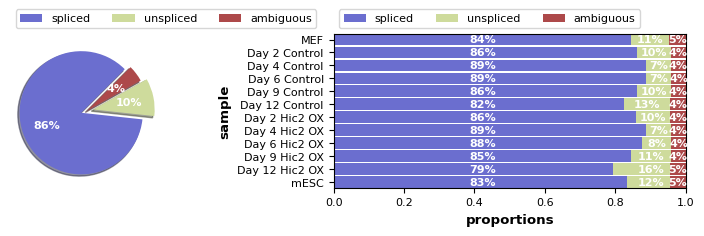

In [3]:
scvelo.pl.proportions(adata, groupby="sample")

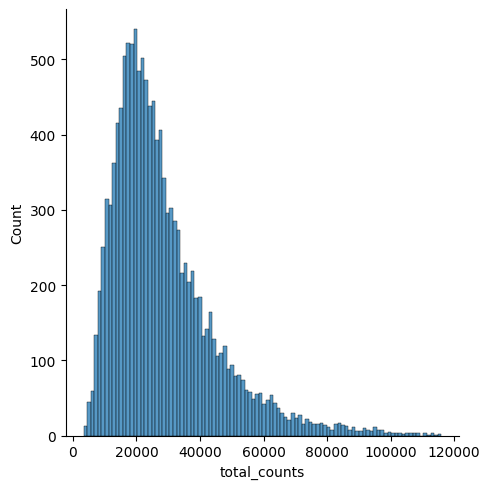

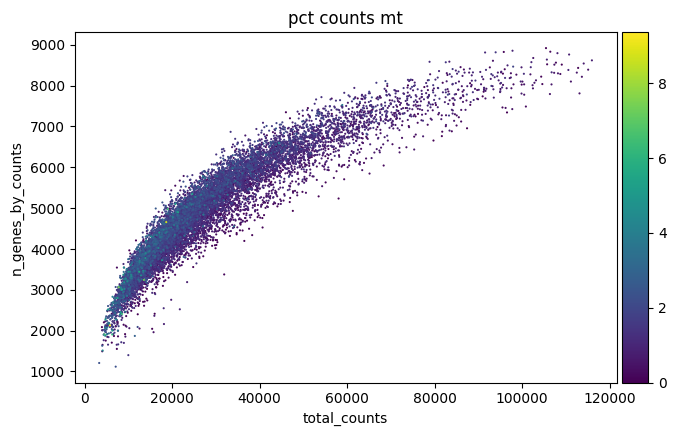

In [4]:
# Quality control

adata.var["mt"] = adata.var_names.str.startswith("mt-")
scanpy.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[], log1p=False
)

scanpy.pp.calculate_qc_metrics(
    adata, inplace=True, percent_top=[], log1p=False
)
histogram = seaborn.displot(adata.obs["total_counts"], bins=100, kde=False)
scatter = scanpy.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

View of AnnData object with n_obs × n_vars = 12791 × 48526
    obs: 'barcode', 'batch', 'sample', 'group', 'day', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'ensemble_ids', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    obsm: 'X_fdl', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'


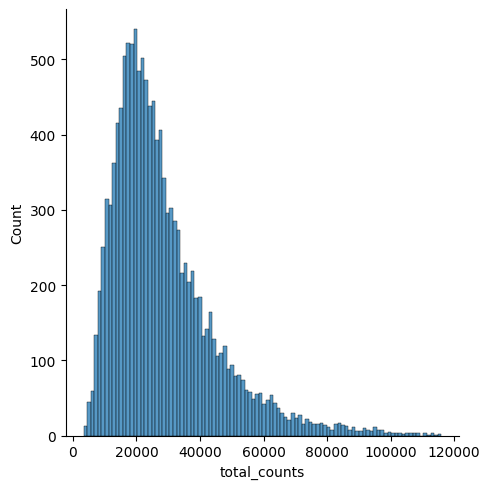

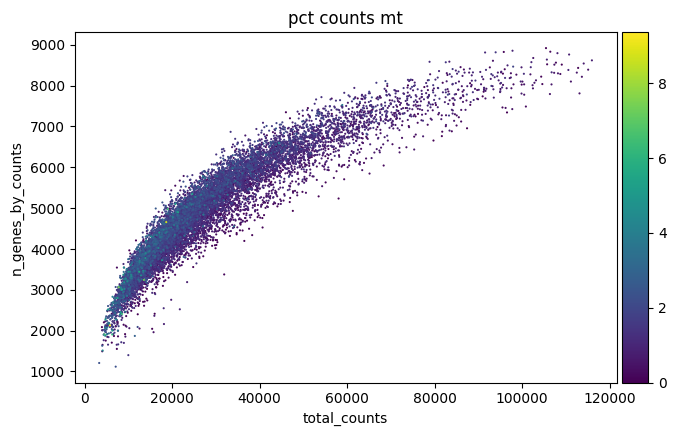

In [5]:
# Filter cells by counts per cell, total counts and percent mitochondrial
included_cells = (adata.obs["n_genes_by_counts"] >= 200)*(adata.obs['total_counts'] <= 150000)*(adata.obs['pct_counts_mt'] < 10)
adata = adata[included_cells]
print(adata)
histogram = seaborn.displot(adata.obs["total_counts"], bins=100, kde=False)
scatter = scanpy.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

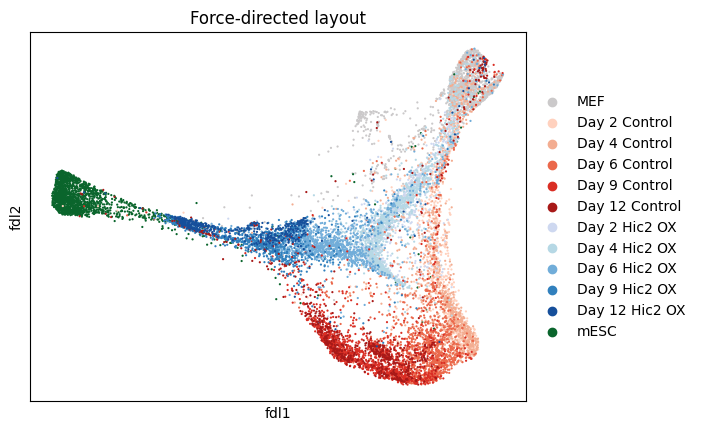

In [6]:
# Plot FDL

scanpy.pl.embedding(basis='fdl', adata=adata, color="sample", size=10, title="Force-directed layout")

In [9]:
print(adata.X.sum())

364026340.0


In [11]:
important_genes = ["Tet1", "Nanog", "Krt8", "Krtdap", "Zfp42", "Dppa4"]

for gene in important_genes:
    print(f"{gene} spliced: {adata[:, gene].layers["spliced"].sum():.1f}, unspliced: {adata[:, gene].layers["unspliced"].sum():.1f}, ambiguous: {adata[:, gene].layers["ambiguous"].sum():.1f}")

Tet1 spliced: 27622.0, unspliced: 21694.0, ambiguous: 31.0
Nanog spliced: 8911.0, unspliced: 1055.0, ambiguous: 142.0
Krt8 spliced: 115993.0, unspliced: 879.0, ambiguous: 0.0
Krtdap spliced: 118750.0, unspliced: 349.0, ambiguous: 278.0
Zfp42 spliced: 68621.0, unspliced: 14262.0, ambiguous: 172.0
Dppa4 spliced: 13857.0, unspliced: 2129.0, ambiguous: 1.0


In [12]:
# Filter and normalize

adata_velocity = adata.copy()

# Filter genes by spliced and unspliced counts and normalize
scvelo.pp.filter_and_normalize(adata_velocity, min_shared_counts=20, n_top_genes=2000)

print(f"Filtered Anndata object:\n{adata_velocity}")

Filtered out 35658 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
Filtered Anndata object:
AnnData object with n_obs × n_vars = 12791 × 2000
    obs: 'barcode', 'batch', 'sample', 'group', 'day', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'ensemble_ids', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'sample_colors', 'log1p'
    obsm: 'X_fdl', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'


/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [13]:
# Find neighbors

scanpy.pp.neighbors(adata_velocity, n_neighbors=15, n_pcs=50) # Uses PCA of X, can be adapted to use UMAP or FDL

In [14]:
# Compute first and second moments

scvelo.pp.moments(adata_velocity, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [15]:
# Calculate EM velocities

scvelo.tl.recover_dynamics(adata_velocity, n_jobs=32)

recovering dynamics (using 32/64 cores)


  0%|          | 0/1455 [00:00<?, ?gene/s]

/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=97915) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:02:22) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [16]:
# Visualize EM velocities

scvelo.tl.velocity(adata_velocity, mode='dynamical')
scvelo.tl.velocity_graph(adata_velocity, n_jobs=32)

computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 32/64 cores)


  0%|          | 0/12791 [00:00<?, ?cells/s]

/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=97915) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_fdl', embedded velocity vectors (adata.obsm)


/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/

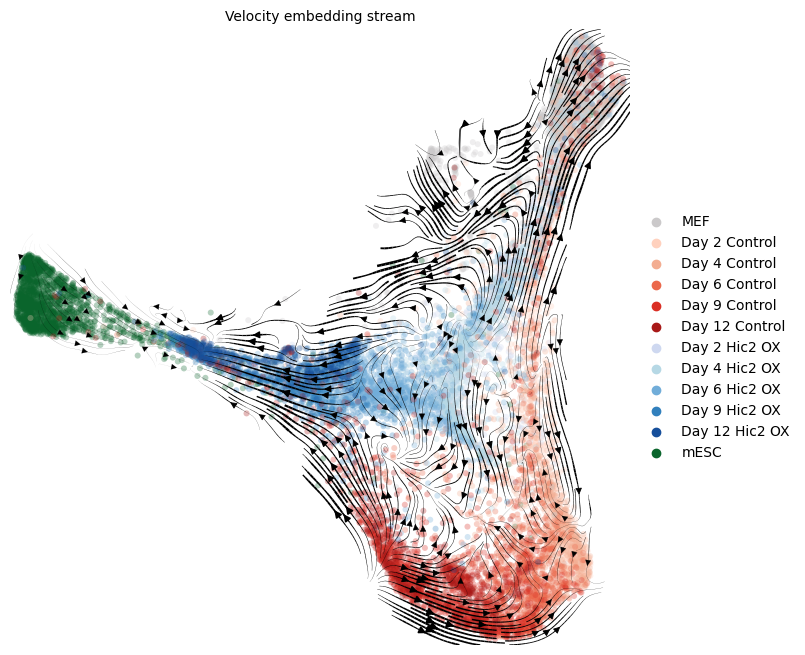

In [17]:
scvelo.pl.velocity_embedding_stream(adata_velocity, basis="fdl", color="sample", legend_loc="right", figsize=(8,8), title="Velocity embedding stream", density=5)

/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/

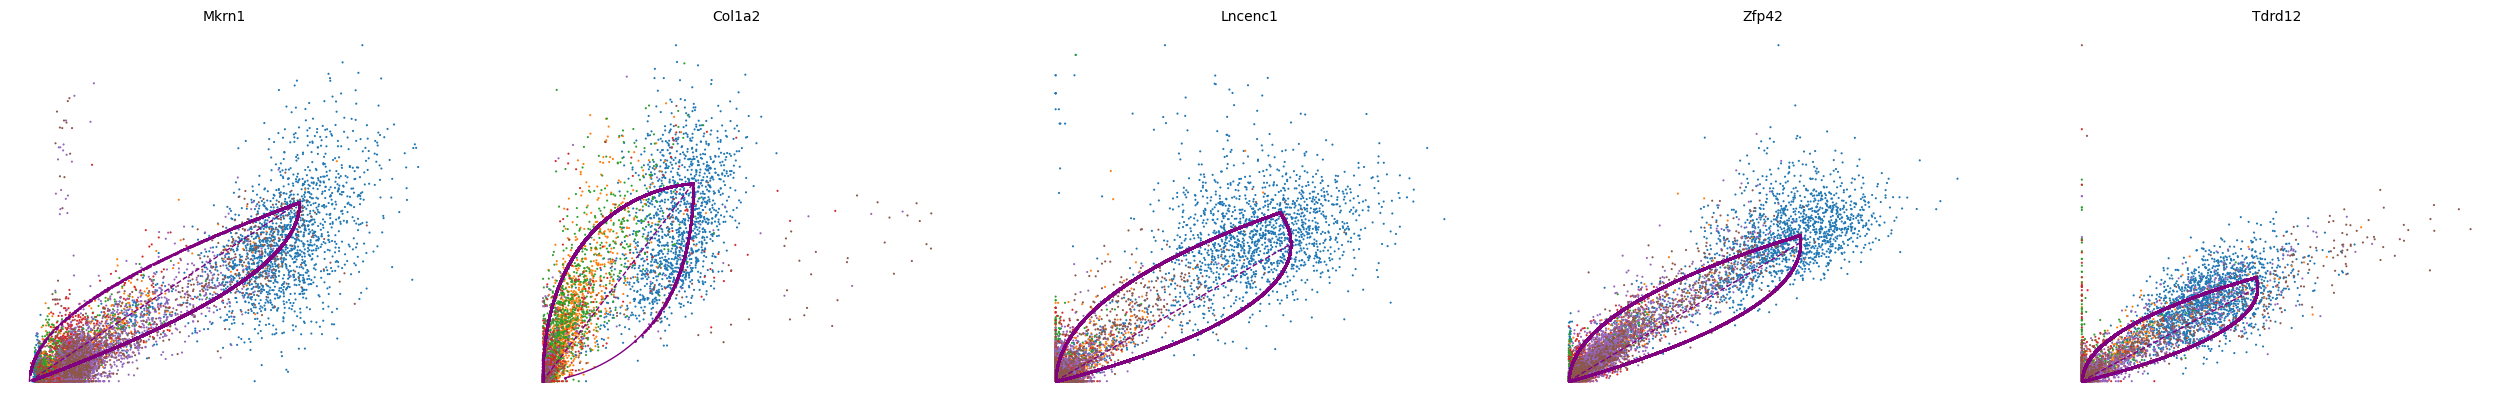

In [18]:
# Plot top genes
top_genes = adata_velocity.var["fit_likelihood"].sort_values(ascending=False).index
scvelo.pl.scatter(adata_velocity, basis=top_genes[:5], color=["day"], frameon=False)

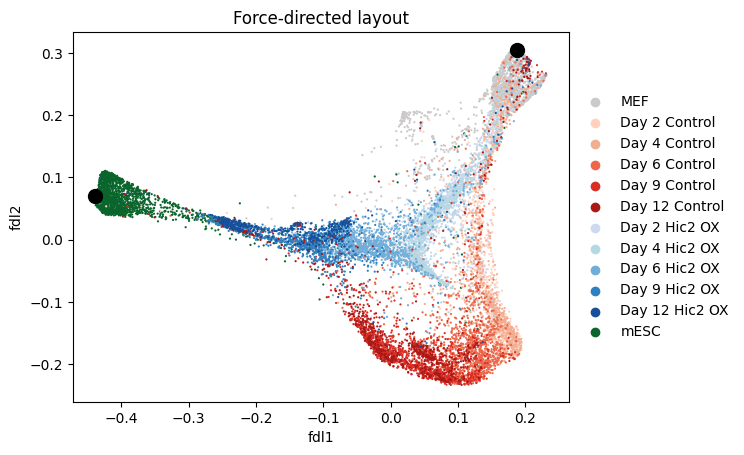

In [19]:
# Find good root and end cells

# Find root
root_filter = (adata_velocity.obs["group"]=="MEF")
# Use MEF cell with largest UMAP2, ignoring outliers with >10
root_index = numpy.argmax(adata_velocity[root_filter].obsm["X_fdl"][:,1])
root_barcode = adata_velocity[root_filter].obs.index[root_index]
adata_velocity.obs["manual_root"] = False
adata_velocity.obs["manual_root"].loc[root_barcode] = True

# Find end
end_filter = adata_velocity.obs["group"]=="mESC"
# Use mESC cell with smallest UMAP1
end_index = numpy.argmin(adata_velocity[end_filter].obsm["X_fdl"][:,0])
end_barcode = adata_velocity[end_filter].obs.index[end_index]
adata_velocity.obs["manual_end"] = False
adata_velocity.obs["manual_end"].loc[end_barcode] = True

ax = scanpy.pl.embedding(basis='fdl', adata=adata_velocity, color="sample", size=10, title="Force-directed layout", show=False)

# Plot UMAP
ax.scatter(*adata_velocity[adata_velocity.obs["manual_end"]].obsm["X_fdl"][0], marker="o", s=100, color="black")
ax.scatter(*adata_velocity[adata_velocity.obs["manual_root"]].obsm["X_fdl"][0], marker="o", s=100, color="black")
ax.yaxis.set_major_locator(matplotlib.ticker.AutoLocator())
ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

pyplot.show()

computing latent time using manual_root, manual_end as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


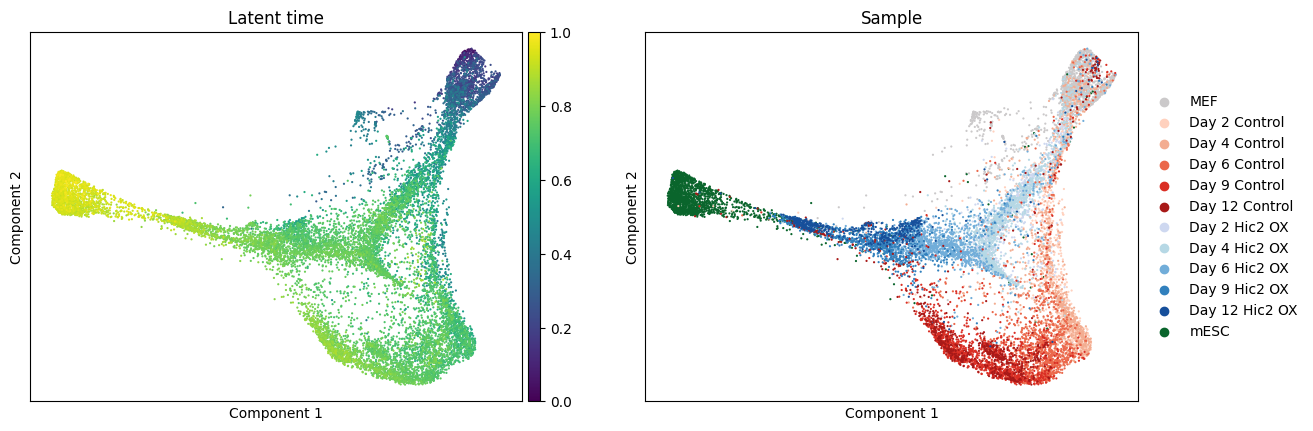

In [20]:
# Latent time

# Calculate latent time
scvelo.tl.recover_latent_time(adata_velocity, root_key="manual_root", end_key="manual_end")

# Plot velocities colored by latent time
axis_list = scanpy.pl.embedding(basis='fdl', adata=adata_velocity, color=["latent_time", "sample"], size=10, title=["Latent time", "Sample"], show=False)
for axis in axis_list:
    axis.set_xlabel("Component 1")
    axis.set_ylabel("Component 2")
pyplot.show()


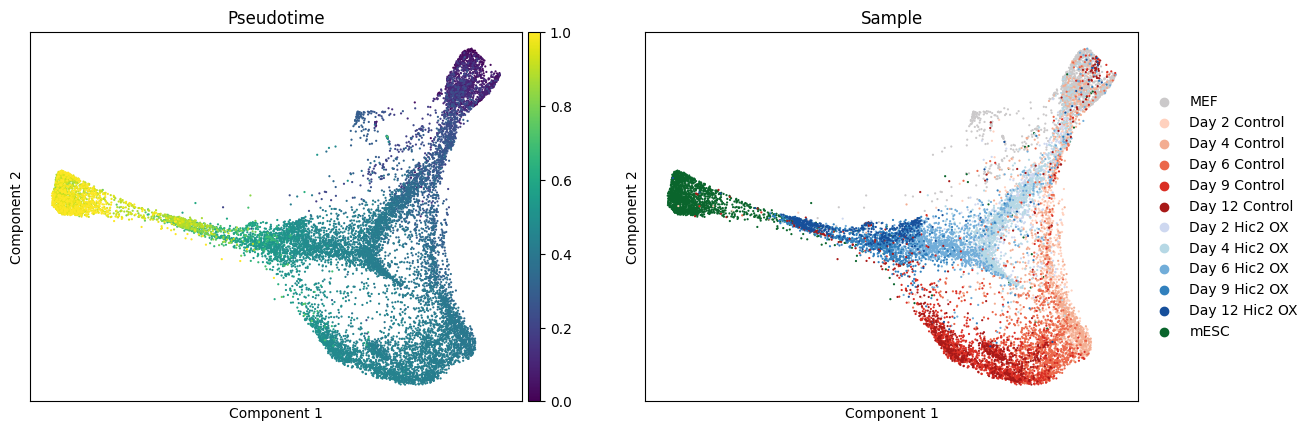

In [21]:
# Pseudotime
global_root_index = numpy.argmax(adata_velocity.obs.index == root_barcode)
global_end_index = numpy.argmax(adata_velocity.obs.index == end_barcode)

scvelo.tl.velocity_pseudotime(adata_velocity, root_key=global_root_index, end_key=global_end_index)

# Plot velocities colored by latent time
axis_list = scanpy.pl.embedding(basis='fdl', adata=adata_velocity, color=["velocity_pseudotime", "sample"], size=10, title=["Pseudotime", "Sample"], show=False)
for axis in axis_list:
    axis.set_xlabel("Component 1")
    axis.set_ylabel("Component 2")
pyplot.show()

In [26]:
# PAGA
adata_velocity.uns['neighbors']['distances'] = adata_velocity.obsp['distances']
adata_velocity.uns['neighbors']['connectivities'] = adata_velocity.obsp['connectivities']

scanpy.tl.diffmap(adata_velocity)
scanpy.pp.neighbors(adata_velocity, n_neighbors=10, use_rep='X_diffmap')
scanpy.tl.draw_graph(adata_velocity, color="sample")

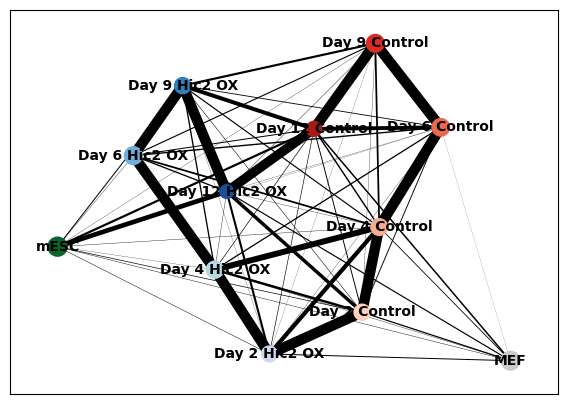

In [23]:
scanpy.tl.paga(adata_velocity, groups='sample')
scanpy.pl.paga(adata_velocity, color='sample')

/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/

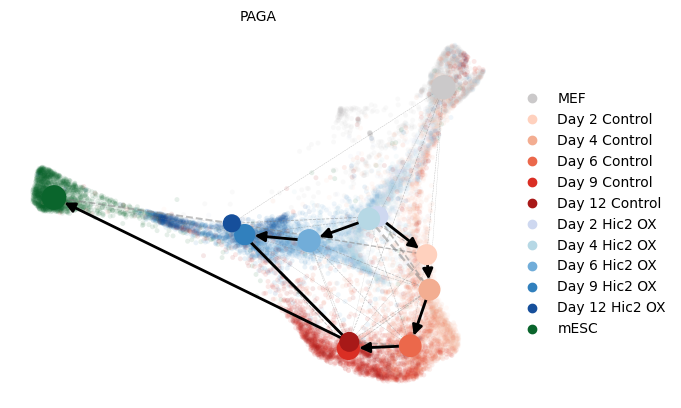

In [28]:
scvelo.pl.paga(adata_velocity, basis='fdl', size=50, alpha=.1, min_edge_width=2, node_size_scale=1.5, title='PAGA')

running PAGA using priors: ['velocity_pseudotime', 'manual_root', 'manual_end']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/miniconda3/envs/velocity/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/

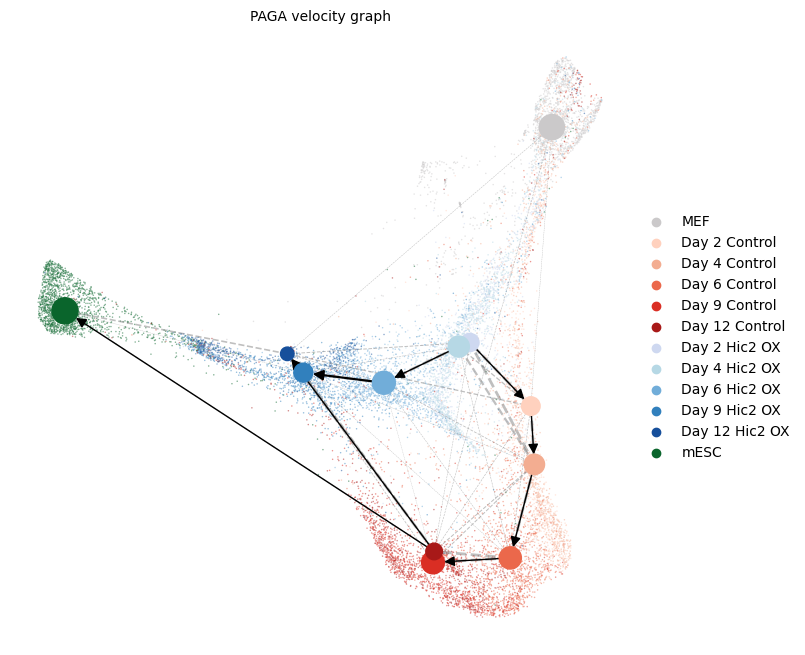

In [29]:
adata_velocity.obs["manual_root"] = adata_velocity.obs["manual_root"].astype(float)
adata_velocity.obs["manual_end"] = adata_velocity.obs["manual_end"].astype(float)
scvelo.tl.paga(adata_velocity, groups="sample", root_key="manual_root", end_key="manual_end", minimum_spanning_tree=True, use_time_prior="velocity_pseudotime")
scvelo.pl.paga(adata_velocity, basis="fdl", figsize=(8,8), node_size_power=1, min_edge_width=1, node_size_scale=1.5, title="PAGA velocity graph")

In [30]:
# Save adata
adata_velocity.write_h5ad(
    "/scratch/lema/m26_losu/velocity_mm10.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)